In [6]:
!ls

drive  feature-selector  sample_data


In [16]:
GLOBAL_PATH = "drive/MyDrive/HSE_local_hw/prod_story/HW_01"
%cd {GLOBAL_PATH}

/content/drive/MyDrive/HSE_local_hw/prod_story/HW_01


In [7]:
!git clone https://github.com/WillKoehrsen/feature-selector

fatal: destination path 'feature-selector' already exists and is not an empty directory.


In [3]:
%cd feature-selector
from feature_selector.feature_selector import FeatureSelector
%cd ../

import pandas as pd

/content/feature-selector
/content


In [7]:
train = pd.read_csv('feature-selector/data/credit_example.csv')
train_labels = train['TARGET']
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,247408,0,Cash loans,F,Y,N,2,108000.0,172512.0,13477.5,144000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.016612,-12665,-2719,-6816.0,-4365,7.0,1,1,0,1,0,0,Laborers,4.0,2,2,TUESDAY,16,0,0,0,0,0,0,...,0.1095,0.1323,0.0194,0.0729,reg oper account,block of flats,0.1484,"Stone, brick",No,1.0,1.0,1.0,1.0,-2622.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,153916,0,Revolving loans,F,Y,Y,2,135000.0,180000.0,9000.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.007274,-12748,-471,-747.0,-4880,17.0,1,1,0,1,0,0,Cooking staff,4.0,2,2,TUESDAY,10,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-520.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,229065,0,Cash loans,F,N,Y,0,112500.0,463500.0,20547.0,463500.0,Family,Pensioner,Secondary / secondary special,Widow,House / apartment,0.026392,-23441,365243,-14237.0,-4634,NaN,1,0,0,1,0,0,NaN,1.0,2,2,THURSDAY,11,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-1285.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,7.0
3,282013,0,Cash loans,F,N,Y,0,135000.0,549882.0,17739.0,459000.0,Unaccompanied,Pensioner,Secondary / secondary special,Single / not married,House / apartment,0.019101,-22793,365243,-690.0,-4478,NaN,1,0,0,1,0,0,NaN,1.0,2,2,WEDNESDAY,12,0,0,0,0,0,0,...,0.0445,0.0572,0.0233,0.0154,reg oper account,block of flats,0.0383,"Stone, brick",No,5.0,1.0,5.0,0.0,-177.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,142266,0,Cash loans,F,N,Y,0,90000.0,518562.0,20695.5,463500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.022625,-13829,-631,-4822.0,-1803,NaN,1,1,0,1,0,0,Sales staff,2.0,2,2,TUESDAY,12,0,0,0,0,0,0,...,NaN,0.0114,NaN,0.0000,NaN,block of flats,0.0088,Block,No,0.0,0.0,0.0,0.0,-718.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0


In [8]:
train = train.drop(columns = ['TARGET'])

In [9]:
fs = FeatureSelector(data = train, labels = train_labels)

In [10]:
fs.identify_missing(missing_threshold=0.6)

17 features with greater than 0.60 missing values.



In [28]:
missing_features = fs.ops['missing']

In [11]:
fs.identify_single_unique()

4 features with a single unique value.



In [12]:
fs.identify_collinear(correlation_threshold=0.5)

51 features with a correlation magnitude greater than 0.50.



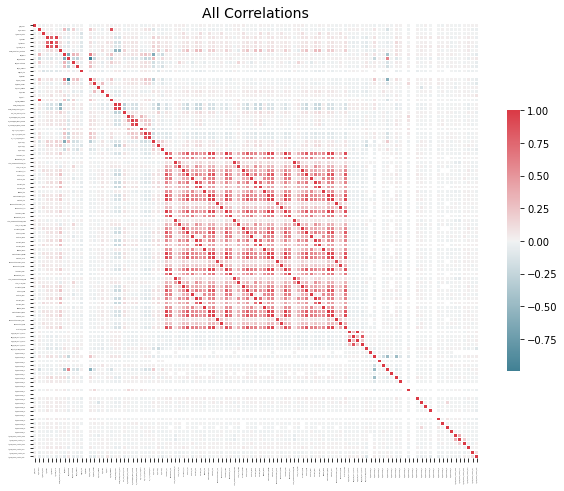

In [13]:
fs.plot_collinear(plot_all=True)

In [14]:
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 10, 
                            early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.254543	valid_0's auc: 0.744248
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.255389	valid_0's auc: 0.75618
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.25439	valid_0's auc: 0.759513
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.256983	valid_0's auc: 0.746019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.264711	valid_0's auc: 0.700648
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.259158	valid_0's auc: 0.715

In [16]:
!ls

adult.data		     Prod_story_01.ipynb  train02.csv
adult_data.csv		     test.csv		  train02.zip
feature-selector	     test.zip		  Untitled0.ipynb
pandas-profiling-master      train01.csv
pandas-profiling-master.zip  train01.zip


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

!"{sys.executable}" -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [1]:
# Standard Library Imports
from pathlib import Path

# Installed packages
import pandas as pd
from ipywidgets import widgets

# Our package
from pandas_profiling import ProfileReport
from pandas_profiling.utils.cache import cache_file

ModuleNotFoundError: ignored

In [4]:
GLOBAL_PATH = "drive/MyDrive/HSE_local_hw/prod_story/HW_01"
%cd {GLOBAL_PATH}

/content/drive/MyDrive/HSE_local_hw/prod_story/HW_01


In [5]:
!ls

adult.data		     Prod_story_01.ipynb  train01.csv  train02.zip
pandas-profiling-master      test.csv		  train01.zip  Untitled0.ipynb
pandas-profiling-master.zip  test.zip		  train02.csv


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression

# зафиксируем значение генератора случайных чисел для воспроизводимости 
SEED = 1

# Функции, которые в дальнейшем понадобятся
def plot_features_scores(model, data, target, column_names, model_type):
    '''Функция для визуализации важности признаков'''
    
    model.fit(data, target)
    
    if model_type == 'rf':
        (pd.DataFrame(data={'score': model['rf'].feature_importances_}, 
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
    elif model_type == 'lr':
        (pd.DataFrame(data={'score': model['lr'].coef_[0]},
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
        
    else:
        raise KeyError('Unknown model_type')

def grid_search(model, gs_params):
    '''Функция для подбора гиперпараметров с помощью перекрёстной проверки'''
     
    gs = GridSearchCV(estimator=model, param_grid=gs_params, refit=True,
                      scoring='roc_auc', n_jobs=-1, cv=skf, verbose=0)
    gs.fit(X, y)
    scores = [gs.cv_results_[f'split{i}_test_score'][gs.best_index_] for i in range(5)]
    print('scores = {}, \nmean score = {:.5f} +/- {:.5f} \
           \nbest params = {}'.format(scores,
                                      gs.cv_results_['mean_test_score'][gs.best_index_],
                                      gs.cv_results_['std_test_score'][gs.best_index_],
                                      gs.best_params_))
    return gs
        
# загрузим данные        
df = pd.read_csv('adult.data')

In [14]:
df

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [13]:
# датасет, с которым будем работать
# оставим только численые признаки
X = df.select_dtypes(exclude=['object']).copy()
# преобразуем целевую переменную
# y = df['salary'].map({'<=50K':0, '>50K':1}).values

X.head()

,39,77516,13,2174,0,40
0,50,83311,13,0,0,13
1,38,215646,9,0,0,40
2,53,234721,7,0,0,40
3,28,338409,13,0,0,40
4,37,284582,14,0,0,40


In [9]:
df

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [15]:
!ls

drive  feature-selector  sample_data


In [19]:
with open('train01.csv', 'r') as f:
    print(f.readline())
    print(f.readline())

id;y;x1;x2;x3;x4;x5;x6;x7;x8;x9;x10;x11;x12;x13;x14;x15;x16;x17;x18;x19;x20;x21;x22;x23;x24;x25;x26;x27;x28;x29;x30;x31;x32;x33;x34;x35;x36;x37;x38;x39;x40;x41;x42

-9196902500682081904;0;-2201458060675810556;01.09.2008;6312572492787112517;182;-6.34741324639e+18;2066976859146697559;0;"[4770.1499999999996 885.49000000000001 1956.3699999999999

